In [2]:
from scipy import signal as sp
import numpy as np
import IPython.display as ipd
import librosa as lbr
import wave
import struct

In [3]:
import wave
import struct

def wavread(sndfile):
    wf = wave.open(sndfile, 'rb')
    nchan = wf.getnchannels()
    bytes_per_sample = wf.getsampwidth()
    rate = wf.getframerate()
    length = wf.getnframes()
    print("Number of channels:", nchan)
    print("Number of bytes per sample:", bytes_per_sample)
    print("Sampling rate:", rate)
    print("Number of samples:", length)
    
    if bytes_per_sample == 2:
        format_string = 'h'  # 16-bit PCM
    else:
        format_string = 'B'  # 8-bit PCM
    
    data = wf.readframes(length)
    shorts = struct.unpack(f'{format_string * nchan * length}', data)
    
    wf.close()
    return shorts, rate

# Load audio file
x, fs = wavread(r"C:\Users\Admin\Desktop\audio1\fold3\Drivingenvironment-1.wav")


Number of channels: 2
Number of bytes per sample: 2
Sampling rate: 44100
Number of samples: 407808


In [4]:
# Play audio
display(ipd.Audio(x, rate = fs ))

In [5]:
#additive zero mean white noise (for -2**15<x<+2**15):
y=x+0.1*(np.random.random(np.shape(x))-0.5)*2**15
display(ipd.Audio(y, rate = fs ))


In [6]:
#make x and y  matrices and transpose them into a column:
x=np.matrix(x).T
y=np.matrix(y).T

In [7]:
#we assume 10 coefficients for our Wiener filter. 
#10 to 12 is a good number for speech signals.
A = np.matrix(np.zeros((100000, 10)))
for m in range(100000):
    A[m,:] = y[m+np.arange(10)].T
#Our matrix has 100000 rows and 10 colums:
print (A.shape)

(100000, 10)


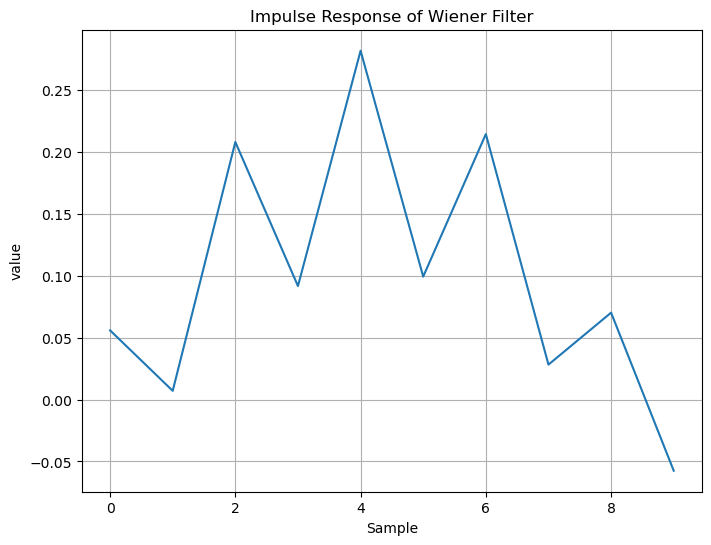

In [8]:
#Compute Wiener Filter:
#Trick: allow (flipped) filter delay of 5 samples to get better working denoising. 
#This corresponds to the center of our Wiener filter.
#The desired signal hence is x[5:100005].
#Observe: Since we have the matrix type, operator '*' is  matrix multiplication!
import matplotlib.pyplot as plt
h=np.linalg.inv(A.T*A)*A.T*x[5:100000+5]
plt.figure(figsize=(8,6))
plt.plot(np.flipud(h)) 
plt.xlabel('Sample')
plt.ylabel('value')
plt.title('Impulse Response of Wiener Filter')
plt.grid()

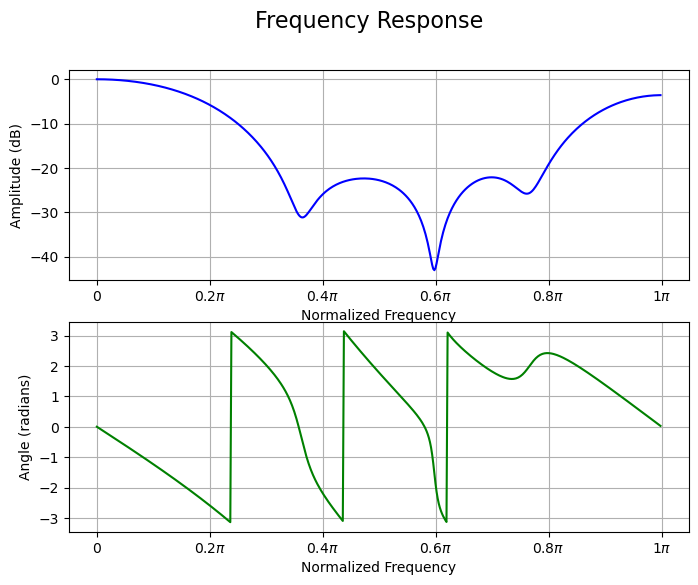

In [9]:

from scipy.signal import freqz
import numpy as np
from matplotlib.ticker import FuncFormatter, MultipleLocator

w, h_response  = freqz(np.flipud(h))

fig=plt.figure(figsize=(8,6))
fig.suptitle('Frequency Response', fontsize=16)
plt.subplot(2,1,1)
plt.plot(w/np.pi, 20 * np.log10(abs(h_response), where=abs(h_response) > 0), 'b')
#plt.ylim((-0.001,0.001))
plt.ylabel('Amplitude (dB)')
plt.xlabel('Normalized Frequency')
plt.grid()
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(
   lambda val,pos: '{:.0g}$\pi$'.format(val) if val !=0 else '0'
))
ax.xaxis.set_major_locator(MultipleLocator(base=0.2))
plt.subplot(2,1,2)
angles = np.angle(h_response)
plt.plot(w/np.pi, angles, 'g')
plt.ylabel('Angle (radians)')
plt.xlabel('Normalized Frequency')
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(
   lambda val,pos: '{:.0g}$\pi$'.format(val) if val !=0 else '0'
))
ax.xaxis.set_major_locator(MultipleLocator(base=0.2))
plt.grid()

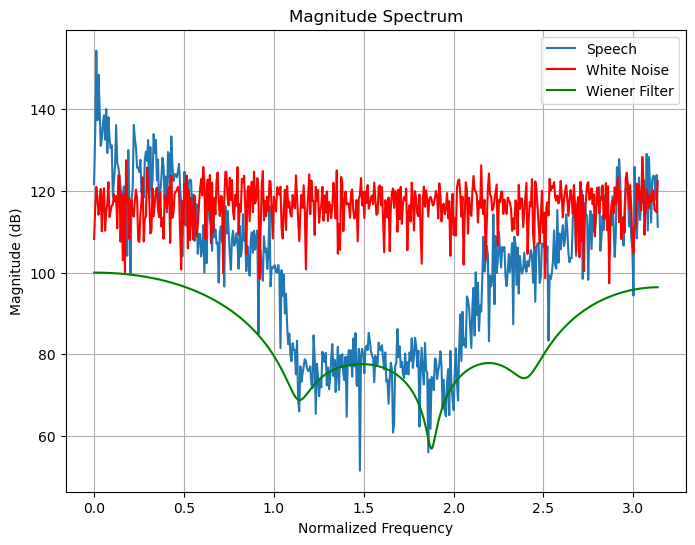

In [10]:
w,Hspeech=sp.freqz(x);
w,Hnoise=sp.freqz(0.1*(np.random.random(np.shape(x))-0.5)*2**15)
w,Hw=sp.freqz(np.flipud(h))
plt.figure(figsize=(8,6))
plt.plot(w,20*np.log10(abs(Hspeech))); 
plt.plot(w,20*np.log10(abs(Hnoise)),'r');
#plot and shift the filter into the vicinity of the signal:
plt.plot(w,20*np.log10(abs(Hw))+100,'g')
plt.xlabel('Normalized Frequency')
plt.ylabel('Magnitude (dB)')
plt.legend(('Speech', 'White Noise', 'Wiener Filter'))
plt.title('Magnitude Spectrum')
plt.grid()

In [11]:
xw = sp.lfilter(np.array(np.flipud(h).T)[0],[1],np.array(y.T)[0])

In [12]:
# Apply the Wiener filter to the noisy audio
xw = sp.lfilter(np.array(np.flipud(h).T)[0], [1], np.array(y.T)[0])

# Save the filtered audio to a WAV file
import scipy.io.wavfile as wavfile
filtered_audio_file = "filtered_audio.wav"
wavfile.write(filtered_audio_file, fs, xw.astype(np.int16))

# Play the filtered audio
display(ipd.Audio(filtered_audio_file))


In [13]:
display(ipd.Audio(xw, rate = fs ))

In [14]:
print( np.shape(x))
#Compute the quadratic error for the first 200000 samples:
print(sum(np.power(y[:200000]-x[:200000],2))/200000)

(815616, 1)
[[894569.46727866]]


In [15]:
print(np.sum(np.power(xw[4:200004]-x[:200000].T,2))/200000)

240783.51830164532


In [16]:
print((A.T*A).shape)
(A.T*A)

(10, 10)


matrix([[1.36844660e+12, 1.23741125e+12, 1.25396329e+12, 1.19856503e+12,
         1.19616530e+12, 1.14407659e+12, 1.13705239e+12, 1.10086901e+12,
         1.10206870e+12, 1.08446568e+12],
        [1.23741125e+12, 1.36845293e+12, 1.23741083e+12, 1.25396963e+12,
         1.19856701e+12, 1.19616875e+12, 1.14407549e+12, 1.13705514e+12,
         1.10086747e+12, 1.10206602e+12],
        [1.25396329e+12, 1.23741083e+12, 1.36845237e+12, 1.23741028e+12,
         1.25396942e+12, 1.19856597e+12, 1.19616930e+12, 1.14407646e+12,
         1.13705598e+12, 1.10086890e+12],
        [1.19856503e+12, 1.25396963e+12, 1.23741028e+12, 1.36845869e+12,
         1.23741225e+12, 1.25397270e+12, 1.19856497e+12, 1.19617230e+12,
         1.14407508e+12, 1.13705356e+12],
        [1.19616530e+12, 1.19856701e+12, 1.25396942e+12, 1.23741225e+12,
         1.36845930e+12, 1.23741322e+12, 1.25397242e+12, 1.19856598e+12,
         1.19617192e+12, 1.14407440e+12],
        [1.14407659e+12, 1.19616875e+12, 1.19856597e+12, 1.2

In [17]:
import librosa
import numpy as np

# Load the audio file
audio_file = r"C:\Users\Admin\Desktop\download (2).wav"
y, sr = librosa.load(audio_file)

# Calculate the power of the signal
signal_power = np.sum(y ** 2)

# Simulate a noisy version of the audio (or load it if you have one)
# Here, you should replace 'noise_audio_file.wav' with your actual noise audio file.
noise_audio_file = r"C:\Users\Admin\Desktop\audio\fold1\DrivingEnvironment-1.wav"
noise, _ = librosa.load(noise_audio_file, duration=len(y)/sr)

# Calculate the power of the noise
noise_power = np.sum(noise ** 2)

# Calculate SNR in dB
snr_db = 10 * np.log10(signal_power / noise_power)

print(f'SNR: {snr_db:.2f} dB')


SNR: 12.29 dB


In [18]:
import librosa
import numpy as np

# Load the audio file
audio_file = r"C:\Users\Admin\Desktop\audio1\fold3\Drivingenvironment-1.wav"
y, sr = librosa.load(audio_file)

# Calculate the power of the signal
signal_power = np.sum(y ** 2)

# Simulate a noisy version of the audio (or load it if you have one)
# Here, you should replace 'noise_audio_file.wav' with your actual noise audio file.
noise_audio_file = r"C:\Users\Admin\Desktop\audio\fold1\DrivingEnvironment-1.wav"
noise, _ = librosa.load(noise_audio_file, duration=len(y)/sr)

# Calculate the power of the noise
noise_power = np.sum(noise ** 2)

# Calculate SNR in dB
snr_db = 10 * np.log10(signal_power / noise_power)

print(f'SNR: {snr_db:.2f} dB')

SNR: 4.02 dB
